<a href="https://colab.research.google.com/github/ayaanzhaque/SuiSense/blob/master/notebooks/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Cleaning, Pre-Processing, and Analysis

# Data Cleaning
This is the code for data cleaning, which means finding missing values and using the meaningful data for the classifier. There aren't that many, but dealing with them is still important

In [1]:
# data analysis imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# NLP Imports
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import wordninja

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ayaanhaque/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayaanhaque/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# data configurations
pd.set_option('display.max_columns', 100)
sns.set_style("darkgrid")

In [3]:
# initializing cvs files
depression = pd.read_csv('../data/depression.csv')
suicide_watch = pd.read_csv('../data/suicide_watch.csv')
casual_convo = pd.read_csv('../data/casual_conversation8-29.csv')

In [4]:
#visualizing depression dataset
pd.set_option('display.max_columns', 500)
casual_convo.head()
casual_convo.columns

Index(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved',
       'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext',
       ...
       'parent_whitelist_status', 'stickied', 'url', 'subreddit_subscribers',
       'created_utc', 'num_crossposts', 'media', 'is_video', 'poll_data',
       'causal'],
      dtype='object', length=107)

### Relevant Data

After viewing the data, there are 100 columns, but barely any of them are really needed for our classifier. We will choose the proper columns and go from there. 

To start, we will look at the title, text body, author username, number of comments, and lastly the URL of the post. 

In [5]:
casual_convo[["title", "selftext", "author",  "num_comments", "causal","url"]].head(5)

,title,selftext,author,num_comments,causal,url
0,r/CasualConversation Lounge,Let's chat!,tizorres,719,2,https://www.reddit.com/r/CasualConversation/co...
1,Does anyone else love gloomy cloudy days?,I have always loved the dark atmosphere before...,Steelcase355,582,2,https://www.reddit.com/r/CasualConversation/co...
2,My (very) pregnant neighbour asked if she coul...,My super pregnant neighbour knocked on my door...,OrcaOne,20,2,https://www.reddit.com/r/CasualConversation/co...
3,"Do you refer to yourself as ""we"" when thinking?",When I think to myself about what I need to do...,starsandwarpaint,39,2,https://www.reddit.com/r/CasualConversation/co...
4,I deleted Facebook,"I finally did it, got rid of Facebook. I would...",MindLessLustLess,506,2,https://www.reddit.com/r/CasualConversation/co...


From these rows, we can see a few posts that people posted. The second post looks like it is from a moderator, as it is a checkin and they have lots of comments. Posts like these potentially have to be removed. 

In [ ]:
suicide_watch[["title", "selftext", "author",  "num_comments", "is_suicide","url"]].head(5)

,title,selftext,author,num_comments,is_suicide,url
0,New wiki on how to avoid accidentally encourag...,We've been seeing a worrying increase in pro-s...,SQLwitch,260,1,https://www.reddit.com/r/SuicideWatch/comments...
1,Reminder: Absolutely no activism of any kind i...,"If you want to recognise an occasion, please d...",SQLwitch,124,1,https://www.reddit.com/r/SuicideWatch/comments...
2,To every single poster here i wanne say one thing,I really fucking feel you,NussNougatCroissant,46,1,https://www.reddit.com/r/SuicideWatch/comments...
3,I just want it all to stop,Everyone ends up hating me eventually. \nMy ps...,hda-SVN-njhdsx,5,1,https://www.reddit.com/r/SuicideWatch/comments...
4,"Nobody gives a fuck until you die, and even th...",NaN,lil_peemis,3,1,https://www.reddit.com/r/SuicideWatch/comments...


This is the suicide dataset. Just from the preview, the titles and posts are clearly different, but it is very hard to distinguish which is which and how to classify that. Post 5 has no body, which also could be problematic as it is a missing value.

In [6]:
# viewing shapes of datasets
print(casual_convo[["title", "selftext", "author",  "num_comments", "causal","url"]].shape)
print(suicide_watch[["title", "selftext", "author",  "num_comments", "is_suicide","url"]].shape)

(804, 6)
(980, 6)


they are a bit different in size, but after cleaning and processing this shouldn't be an issue. 

In [7]:
# reading post 118 from the depression dataset
print(depression["selftext"][80])
len(depression["selftext"][80])

Hi! I've been battling depression for the past two years, officially diagnosed in summer 2019, currently on medication &amp; therapy. Beating myself up every. single. day. for just being "lazy", and "not being able to get it together", as well as struggling with the thought that i somehow just tricked everybody (including the doctors) into thinking that i have depression when really i dont. 🥴  
Anyways, after another horrifying therapy session of me complaining that i am really just a piece of shit that only wants to sleep 24/7, wasting her life away not accomplishing anything, my therapist urged me to list all the things which i do DO and sort of look at them from afar and try to practice gratitude and appreciation. Here it is:

1) most days, I am able to make myself brush my teeth and on the good days even take a shower  
2) i could have given up on all work  to kind of "sleep through" my depression (my partner can support me financially with no trouble) however as tempting as it is 

1874

In [8]:
# reading post 118 from the suicide dataset
print(suicide_watch["selftext"][118])
len(suicide_watch["selftext"][118])

I'm an 18 year old with severe depression, anxiety, ADHD, borderline personality disorder and DID at a point in my life. But I'm slowly recovering.

I have always felt like I never belonged to this world, because I am "too imaginative" and "too kind". I behave "not like how people should". I'm mostly well-liked, but I know they think I'm a weirdo. Everyone does.

It's final exam time for us, and I have to secure good marks, otherwise I won't be able to enter any good streams in a good college. It would be the end of my future. My family is in a financial crunch, but they give up everything for me. I am dead-set on helping my friends get through their depression and suicidal tendencies, but I'm failing at that. I have had three attempts, but I was saved by a person, who himself was alexithymic (I think) and suicidal. He still is, and he says if he doesn't do well, he will commit suicide.

I don't know what I'm gonna do if I don't perform the way I should. But I certainly know that I wil

1172

just from reading them, they look pretty similar. However, the stories of both people are completely different and one of them is suicidal. The second person explicitly says they will die in 3 months, but the first post makes no such remarks. A classifier could do a good job of distinguishing between these two. Let's read two more. 

In [9]:
print(depression["selftext"][6])

why does it hurt so much? Why can’t I be happy without it? There’s this empty void in my heart that gets bigger everyday. I’m just waiting until it eats me up, since I’ll never have 2 sided love.


In [ ]:
print(suicide_watch["selftext"][100])

I wanted to die starting in Jan 2018, but things have only gotten worse.

In summer 2018, those fucks on the Suicide Prevention chatroom called the police when I expressed suicidal ideations, so I was kidnapped and sent to a series of hospital-prisons with junk medical staff. I lost my job due to the hospital stay - and my apartment, car, and dog shortly followed.

Can't get a decent job because my resume is now all fucked up and I have no connections, and I refuse to go back to miserable jobs that pay horribly. I'd rather die than do that for life.

I am about to be sued on $4K debt, and then yesterday I was handed a $6.5K medical bill for treatment that would have been 100% unnecessary had I still had insurance and was able to go to regular check ups.

You fucks on the Suicide Prevention line made my life demonstrably worse. You destroyed the mechanisms that kept me going as an independent and self-sufficient human. Now I have nothing and am in a far worse position (logistically spea

between these two posts, there is a clear distinction, but it would be hard for a regular person reading it to be sure. Only a classifier generalized on thousands of peoples suffering could do this. But the first post talks about how their life is getting better, while the second explains that the person thinks that it is time to die. 

In [10]:
casual_convo = casual_convo.rename(columns={'causal': 'is_suicide'})

In [18]:
# the 5 columns we chose seem good so lets shorten the datasets. 
dep_columns = depression[["title", "selftext", "author",  "num_comments", "is_suicide","url"]]
sui_columns = suicide_watch[["title", "selftext", "author",  "num_comments", "is_suicide","url"]]
cas_columns = casual_convo[["title", "selftext", "author",  "num_comments", "is_suicide","url"]]

# lets combine the datasets into one massive dataset. 
combined_data = pd.concat([dep_columns,sui_columns, cas_columns],axis=0, ignore_index=True)    
combined_data

,title,selftext,author,num_comments,is_suicide,url
0,Our most-broken and least-understood rules is ...,We understand that most people who reply immed...,SQLwitch,133,0,https://www.reddit.com/r/depression/comments/d...
1,Regular Check-In Post,Welcome to /r/depression's check-in post - a p...,circinia,1644,0,https://www.reddit.com/r/depression/comments/e...
2,I hate it so much when you try and express you...,I've been feeling really depressed and lonely ...,TheNewKiller69,8,0,https://www.reddit.com/r/depression/comments/f...
3,I went to the hospital because I was having re...,I literally broke down crying and asked to go ...,Jazzlecrab,15,0,https://www.reddit.com/r/depression/comments/f...
4,Cake day for me,Any kind soul want to give a depressed person ...,Depressed_Kid786,37,0,https://www.reddit.com/r/depression/comments/f...
...,...,...,...,...,...,...
2696,Have y’all had one of those eye opening moment...,So I was hanging out with a friend and we stop...,bigoof10,1,2,https://www.reddit.com/r/CasualConversation/co...
2697,"Not trying to be mean, but why do rich people ...",I understand some people might need it after a...,Void1992,10,2,https://www.reddit.com/r/CasualConversation/co...
2698,thoughts on horror movies,what are your guys thoughts on horror movies? ...,donkeyballs8291,5,2,https://www.reddit.com/r/CasualConversation/co...
2699,Cut my father-in-law's fibre optic cable,While installing an ethernet cable to have Wi-...,slipperman1,0,2,https://www.reddit.com/r/CasualConversation/co...


In [19]:
# saving the combined data in our datasets folder
combined_data.to_csv('../data/combined_data_w_casual.csv', index = False)

In [20]:
# checking for missing values
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2701 entries, 0 to 2700
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         2701 non-null   object
 1   selftext      2636 non-null   object
 2   author        2701 non-null   object
 3   num_comments  2701 non-null   int64 
 4   is_suicide    2701 non-null   int64 
 5   url           2701 non-null   object
dtypes: int64(2), object(4)
memory usage: 126.7+ KB


it looks like the only missing values are in the text body, which makes sense. 

In [21]:
# looking at the posts with missing text values
combined_data[combined_data["selftext"].isnull()].head(10)

,title,selftext,author,num_comments,is_suicide,url
184,Can someone recommend good qualities in therap...,NaN,eito_8,2,0,https://www.reddit.com/r/depression/comments/f...
921,"Nobody gives a fuck until you die, and even th...",NaN,lil_peemis,3,1,https://www.reddit.com/r/SuicideWatch/comments...
923,I have two brothers who have killed themselves...,NaN,ArsenalOwl,1,1,https://www.reddit.com/r/SuicideWatch/comments...
925,I want to die I want to die I want to die,NaN,alynde,4,1,https://www.reddit.com/r/SuicideWatch/comments...
934,"I am so sorry, but it has gotten worse",NaN,SmushyKidK,4,1,https://www.reddit.com/r/SuicideWatch/comments...
937,I want to douse my body in gasoline and set my...,NaN,SalehRobbins,3,1,https://www.reddit.com/r/SuicideWatch/comments...
941,I can't do this anymore,NaN,sappy_banana,4,1,https://www.reddit.com/r/SuicideWatch/comments...
957,"If I had a gun, I’d blow my fucking brains out...",NaN,CGM2004,1,1,https://www.reddit.com/r/SuicideWatch/comments...
960,This world is a joke.,NaN,crybaby1577,11,1,https://www.reddit.com/r/SuicideWatch/comments...
964,I think I’m ready,NaN,___horse___,4,1,https://www.reddit.com/r/SuicideWatch/comments...


The posts with missing values are either very concise in the title and to the point, or the main text is basically in the title. Luckily, there aren't that many posts with missing values. However, most of the null values are in the suicide dataset, which makes sense but also could be troublesome for our classifier. Maybe using the titles as the text would be a good approach. 

In [22]:
combined_data["is_suicide"][combined_data["selftext"].isnull()].value_counts()

1    64
0     1
Name: is_suicide, dtype: int64

In [23]:
# the best approach for the null values it to just fill them with "emptypost"
combined_data["selftext"].fillna("emptypost",inplace=True)

In [24]:
# checking if filling missing values worked
combined_data[combined_data["selftext"].isin(["emptypost"])].head()

,title,selftext,author,num_comments,is_suicide,url
184,Can someone recommend good qualities in therap...,emptypost,eito_8,2,0,https://www.reddit.com/r/depression/comments/f...
921,"Nobody gives a fuck until you die, and even th...",emptypost,lil_peemis,3,1,https://www.reddit.com/r/SuicideWatch/comments...
923,I have two brothers who have killed themselves...,emptypost,ArsenalOwl,1,1,https://www.reddit.com/r/SuicideWatch/comments...
925,I want to die I want to die I want to die,emptypost,alynde,4,1,https://www.reddit.com/r/SuicideWatch/comments...
934,"I am so sorry, but it has gotten worse",emptypost,SmushyKidK,4,1,https://www.reddit.com/r/SuicideWatch/comments...


In [25]:
# checking entire dataset for missing values
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2701 entries, 0 to 2700
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         2701 non-null   object
 1   selftext      2701 non-null   object
 2   author        2701 non-null   object
 3   num_comments  2701 non-null   int64 
 4   is_suicide    2701 non-null   int64 
 5   url           2701 non-null   object
dtypes: int64(2), object(4)
memory usage: 126.7+ KB


# Data Preprocessing
The posts are all written in different punctuation and capitalizations, so standardizing the data is an important first step. 

### Preprocessing Functions
Let's begin by removing capitalizations, reducing sentences to base words, and removing punctuation. We will add this as a new column to our data.

In [26]:
def processing_text(series_to_process):
    new_list = []
    tokenizer = RegexpTokenizer(r'(\w+)')
    lemmatizer = WordNetLemmatizer()
    for i in range(len(series_to_process)):
        # tokenized item in a new list
        dirty_string = (series_to_process)[i].lower()
        words_only = tokenizer.tokenize(dirty_string) # words_only is a list of only the words, no punctuation
        #Lemmatize the words_only
        words_only_lem = [lemmatizer.lemmatize(i) for i in words_only]
        # removing stop words
        words_without_stop = [i for i in words_only_lem if i not in stopwords.words("english")]
        # return seperated words
        long_string_clean = " ".join(word for word in words_without_stop)
        new_list.append(long_string_clean)
    return new_list

In [27]:
# checking to see if the new columns were added
combined_data["selftext_clean"] = processing_text(combined_data["selftext"])
combined_data["title_clean"] = processing_text(combined_data["title"])
pd.set_option("display.max_colwidth", 100)
combined_data.head(8)

,title,selftext,author,num_comments,is_suicide,url,selftext_clean,title_clean
0,"Our most-broken and least-understood rules is ""helpers may not invite private contact as a first...",We understand that most people who reply immediately to an OP with an invitation to talk private...,SQLwitch,133,0,https://www.reddit.com/r/depression/comments/doqwow/our_mostbroken_and_leastunderstood_rules_is/,understand people reply immediately op invitation talk privately mean help type response usually...,broken least understood rule helper may invite private contact first resort made new wiki explain
1,Regular Check-In Post,Welcome to /r/depression's check-in post - a place to take a moment and share what is going on a...,circinia,1644,0,https://www.reddit.com/r/depression/comments/exo6f1/regular_checkin_post/,welcome r depression check post place take moment share going accomplishment want talk standalon...,regular check post
2,"I hate it so much when you try and express your feelings to your parents, but they turn it aroun...","I've been feeling really depressed and lonely lately from my job, I'm a full time late night jan...",TheNewKiller69,8,0,https://www.reddit.com/r/depression/comments/fedwbi/i_hate_it_so_much_when_you_try_and_express_y...,feeling really depressed lonely lately job full time late night janitor courthouse 10 mile away ...,hate much try express feeling parent turn around compare suffering
3,"I went to the hospital because I was having really bad panic attacks, and theycontinued in there...","I literally broke down crying and asked to go home, another nurse was watching me while I was cr...",Jazzlecrab,15,0,https://www.reddit.com/r/depression/comments/feel0k/i_went_to_the_hospital_because_i_was_having/,literally broke cry asked go home another nurse wa watching wa cry saying wanted keep longer kep...,went hospital wa really bad panic attack theycontinued ended collapsing nurse wa trying help sai...
4,Cake day for me,Any kind soul want to give a depressed person karma.\n\n\nEdit: Thanks everyone and especially f...,Depressed_Kid786,37,0,https://www.reddit.com/r/depression/comments/fe6ua3/cake_day_for_me/,kind soul want give depressed person karma edit thanks everyone especially sub hope overcome dep...,cake day
5,sorry but why the fuck is life like this,literally though. have i done anything wrong,angelshum10,13,0,https://www.reddit.com/r/depression/comments/fecd9s/sorry_but_why_the_fuck_is_life_like_this/,literally though done anything wrong,sorry fuck life like
6,I hate love,why does it hurt so much? Why can’t I be happy without it? There’s this empty void in my heart t...,DaRkNeSSReDCrusader,29,0,https://www.reddit.com/r/depression/comments/feb4tq/i_hate_love/,doe hurt much happy without empty void heart get bigger everyday waiting eats since never 2 side...,hate love
7,This world has no place for people like me.,A bit of context. I'm an American. I'm black. I'm big. I'm ugly. And I'm autistic. I work as an ...,InsertANameHeree,2,0,https://www.reddit.com/r/depression/comments/fegd6t/this_world_has_no_place_for_people_like_me/,bit context american black big ugly autistic work aircraft mechanic go every day le see point co...,world ha place people like


Cleaning the titles and text worked, and that is important for our classifier to simplify the process and create a clearer distinction between the two datasets. 

In [29]:
# checking selftext_clean
pd.set_option("display.max_colwidth", 1000)
combined_data[["selftext","selftext_clean"]].tail(2)

,selftext,selftext_clean
2699,"While installing an ethernet cable to have Wi-Fi around the house, I cut the fibre optic cable thinking it was an old unused cable, effectively shutting off internet and TV in his home. I never had done any work of this sort, and now I never will again. How did your week start?",installing ethernet cable wi fi around house cut fibre optic cable thinking wa old unused cable effectively shutting internet tv home never done work sort never week start
2700,"How do you guys feel about going back to school? Is it still worth it?\n\nI read articles about college during COVID and how they are getting shut down before school even starts. Higher education are blaming the students when in my opinion, its not just there fault. NYT says colleges are choosing between Safety and keeping Reputation. But is it reputation or just plain money.\n\nThe answer may be obvious but I am just curious how everyone feels about this. I am a senior in college and my school wants to bring us back in the beginning of September but keep changing the dates, enforcing mask, and charging us still for utilities and buildings we aren't or can't use during this crazy time. Typical of higher education stuff..",guy feel going back school still worth read article college covid getting shut school even start higher education blaming student opinion fault nyt say college choosing safety keeping reputation reputation plain money answer may obvious curious everyone feel senior college school want bring u back beginning september keep changing date enforcing mask charging u still utility building use crazy time typical higher education stuff


In [30]:
# testing wordninja
author_test = []
for i in range(10):
    splits_list = wordninja.split(combined_data["author"][i])
    combined_string = " ".join(splits_list)
    author_test.append(combined_string)
test_dict = {combined_data["author"][i]:author_test[i] for i in range(10)}
print(test_dict)

{'SQLwitch': 'SQL witch', 'circinia': 'c irc in i a', 'TheNewKiller69': 'The New Killer 69', 'Jazzlecrab': 'Jazz le crab', 'Depressed_Kid786': 'Depressed Kid 786', 'angelshum10': 'angels hum 10', 'DaRkNeSSReDCrusader': 'DaRkNeSS ReD Crusader', 'InsertANameHeree': 'Insert A Name Here e', 'chroms-leather-belt': 'ch roms leather belt', 'deppressionthrowaway': 'dep press ion throwaway'}


In [31]:
# lets also clean the author names
def processing_author_names(series_to_process):
    author_split = []
    for i in range(len(series_to_process)):
        splits_list = wordninja.split(series_to_process[i])
        combined_string = " ".join(splits_list)
        author_split.append(combined_string)
    new_list = []
    tokenizer = RegexpTokenizer(r'(\w+)')
    lemmatizer = WordNetLemmatizer()
    for i in range(len(author_split)):
        #TOKENISED ITEM(LONG STRING) IN A LIST
        dirty_string = (author_split)[i].lower()
        words_only = tokenizer.tokenize(dirty_string) #WORDS_ONLY IS A LIST THAT DOESN'T HAVE PUNCTUATION
        #LEMMATISE THE ITEMS IN WORDS_ONLY
        words_only_lem = [lemmatizer.lemmatize(i) for i in words_only]
        #REMOVING STOP WORDS FROM THE LEMMATIZED LIST
        words_without_stop = [i for i in words_only_lem if i not in stopwords.words("english")]
        #RETURN SEPERATED WORDS INTO LONG STRING
        long_string_clean = " ".join(word for word in words_without_stop)
        new_list.append(long_string_clean)
    return new_list

In [32]:
combined_data["author_clean"]= processing_author_names(combined_data["author"])

# checking author_clean
pd.set_option("display.max_colwidth", 100)
combined_data[["author","author_clean"]].tail(10)

,author,author_clean
2691,GrovPastaSwag03,gro v pasta swag 03
2692,snskr,sn kr
2693,soldiercross,soldier cross
2694,amymarie1996,amy marie 1996
2695,batmanthecowboy,batman cowboy
2696,bigoof10,big 10
2697,Void1992,void 1992
2698,donkeyballs8291,donkey ball 8291
2699,slipperman1,slipper man 1
2700,naturally_ares,naturally


so it doesn't work that well, but it isn't too big a deal because the author names don't matter as much, as long as it is simplified it is working well.

In [33]:
# Making sure there is no new missing values added
combined_data.isnull().sum()

title             0
selftext          0
author            0
num_comments      0
is_suicide        0
url               0
selftext_clean    0
title_clean       0
author_clean      0
dtype: int64

In [34]:
combined_data.to_csv('../data/cleaned_data_casual.csv', index = False)

### Data Preprocessing Complete
This was a relatively simple process because we only have a few attributes to adjust. We have 3 attributes to train our model on now.

# EDA
For EDA, let's just go through a few things to better understand the dataset so we can properly build our classifier

In [ ]:
# masking for visualization
suicide_posts = combined_data[combined_data["is_suicide"] ==1]["selftext_clean"]
suicide_titles = combined_data[combined_data["is_suicide"] ==1]["title_clean"]
suicide_authors = combined_data[combined_data["is_suicide"] ==1]["author_clean"]

depression_posts = combined_data[combined_data["is_suicide"] ==0]["selftext_clean"]
depression_titles = combined_data[combined_data["is_suicide"] ==0]["title_clean"]
depression_authors = combined_data[combined_data["is_suicide"] ==0]["author_clean"]

Let's look at the top words used

In [ ]:
# function for visualization
def plot_most_used_words(category_string, data_series, palette, image_mask):
    #CHECKING OUT COMMON WORDS IN r/SuicideWatch USING CVEC
    cvec = CountVectorizer(stop_words='english')
    cvec.fit(data_series)
    #CREATING A DATAFRAME OF EXTRACTED WORDS
    created_df = pd.DataFrame(cvec.transform(data_series).todense(),
                              columns=cvec.get_feature_names())
    total_words = created_df.sum(axis=0)
    
    #<<<BARPLOT>>>
    #CREATING A FINAL DATAFRAME OF THE TOP 20 WORDS
    top_20_words = total_words.sort_values(ascending = False).head(20)
    top_20_words_df = pd.DataFrame(top_20_words, columns = ["count"])
    #PLOTTING THE COUNT OF THE TOP 20 WORDS
    sns.set_style("white")
    plt.figure(figsize = (15, 8), dpi=300)
    ax = sns.barplot(y= top_20_words_df.index, x="count", data=top_20_words_df, palette = palette)
    
    plt.xlabel("Count", fontsize=9)
    plt.ylabel('Common Words in {}'.format(category_string), fontsize=9)
    plt.yticks(rotation=-5)

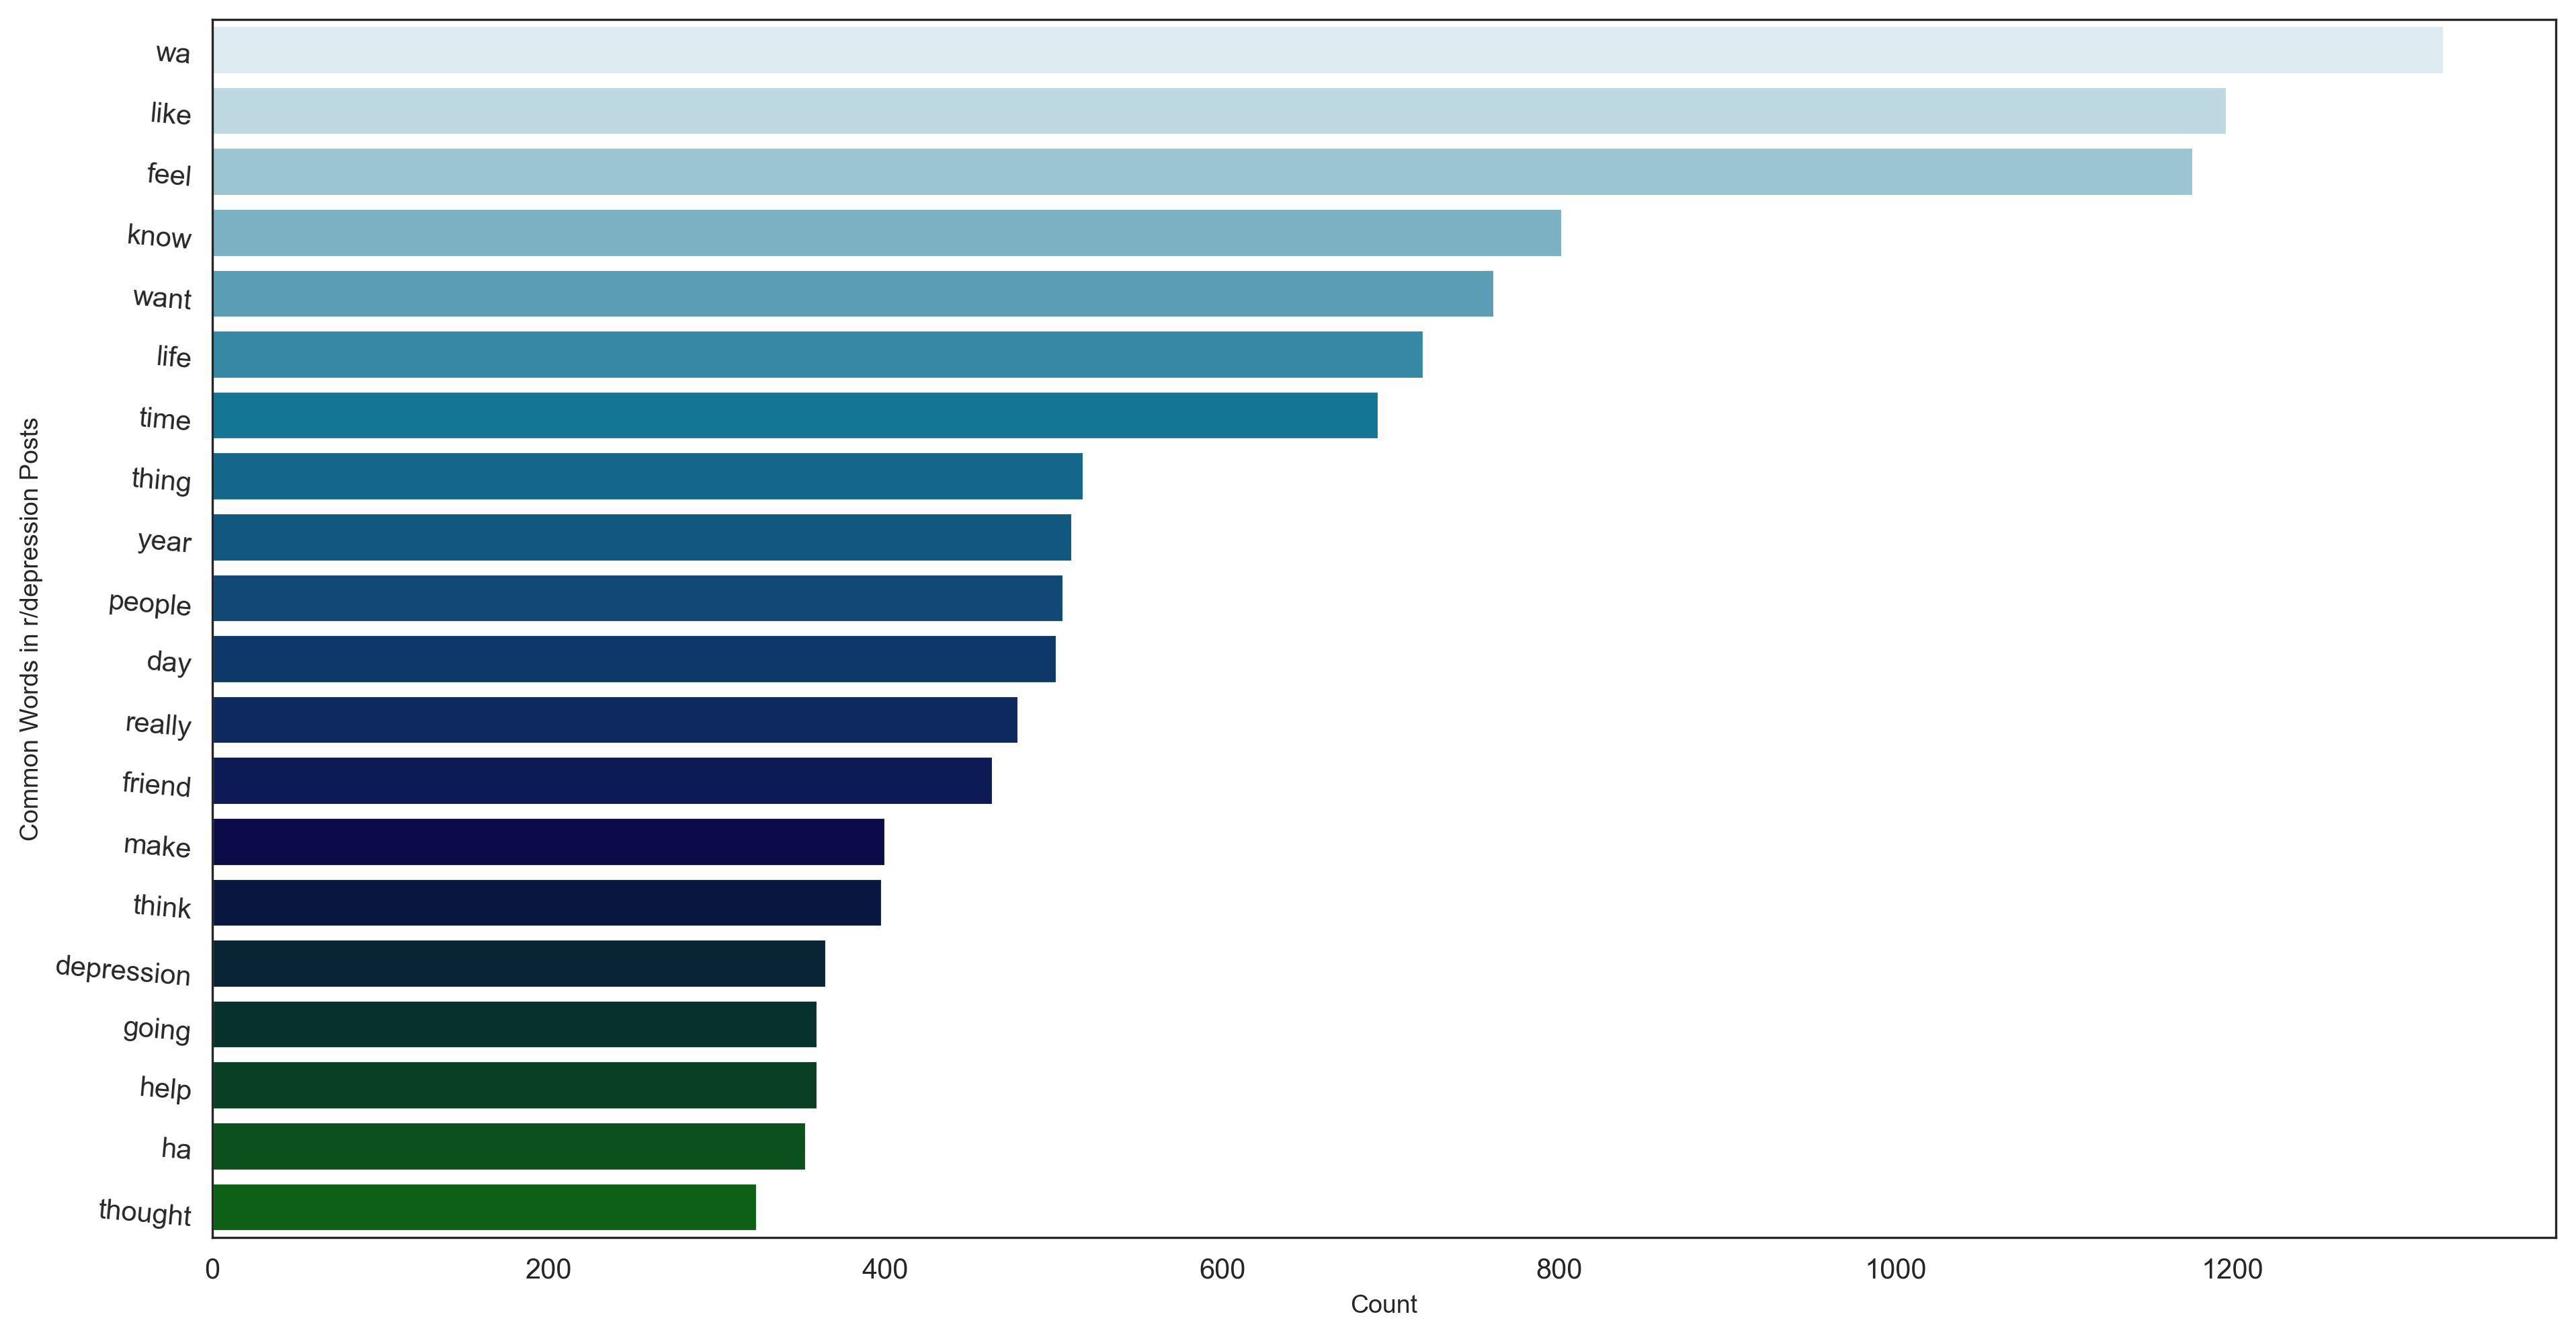

In [ ]:
plot_most_used_words("r/depression Posts", depression_posts, palette="ocean_r", image_mask="../assets/depression_mask.png")

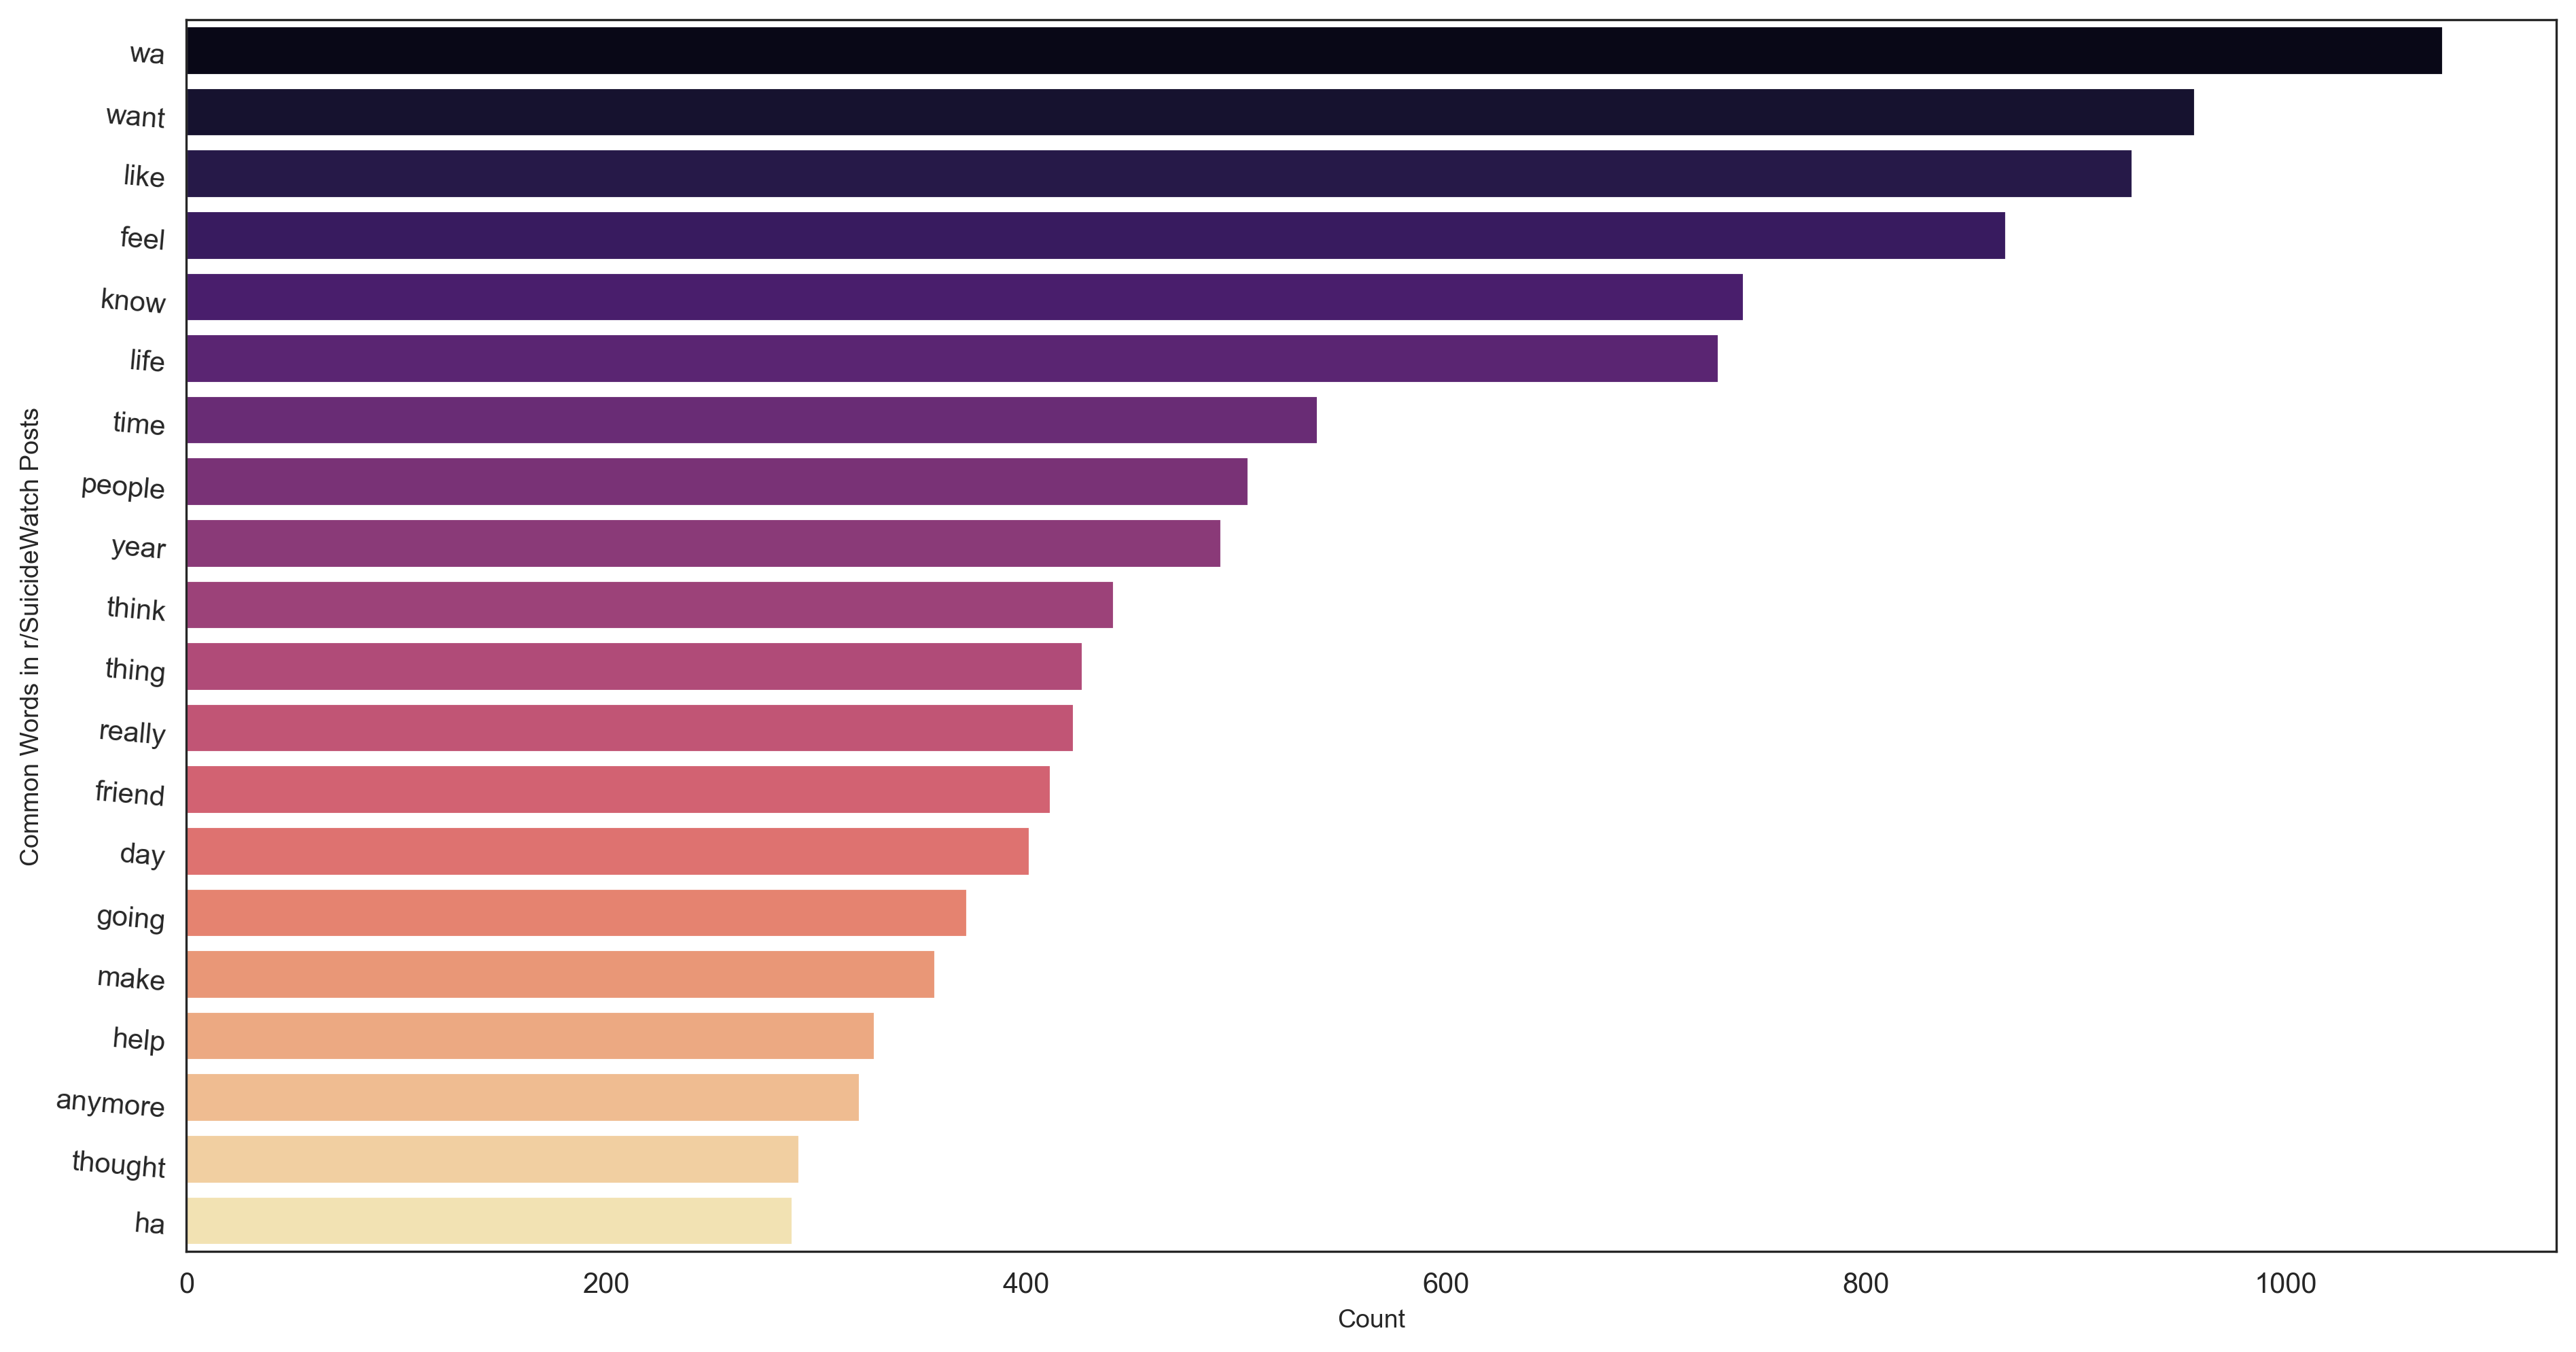

In [ ]:
plot_most_used_words("r/SuicideWatch Posts", suicide_posts, palette="magma", image_mask="../assets/suicide_mask.png")

This shows a clear problem for classification. The top words in post datasets are very similar, which could make the job of the classifier much harder, especially considering that it is not just binary classification.

Maybe using titles will be a better approach.

Lets see which users post a lot and more often in both subreddits to help our classifier

In [ ]:
# looking at top authors
combined_data["author"].value_counts().head(20)

[deleted]           11
Vivid-Smile          5
throaway8297338      4
snakesnack148        4
outakuslayer69       4
lIlFlashIlI          3
SuperDuperPewper     3
SQLwitch             3
TheGrandMan10        3
SeaSaltSaw           3
LifeisCrumbling      3
SilentPost3          3
missmisery8          3
enk9898              3
AlinaAngelMtF        3
unicorn6642          3
vadimuha             3
Jefvv                2
Jackbright682        2
Hlp4me               2
Name: author, dtype: int64

In [ ]:
#isolating authors who posted more than once
df_author_counts=(pd.DataFrame(combined_data["author"].value_counts()))
df_author_counts.reset_index(level=0, inplace=True)
authors_posting_more_than_once = list(df_author_counts[df_author_counts["author"]>1]["index"])
authors_posting_more_than_once

['[deleted]',
 'Vivid-Smile',
 'throaway8297338',
 'snakesnack148',
 'outakuslayer69',
 'lIlFlashIlI',
 'SuperDuperPewper',
 'SQLwitch',
 'TheGrandMan10',
 'SeaSaltSaw',
 'LifeisCrumbling',
 'SilentPost3',
 'missmisery8',
 'enk9898',
 'AlinaAngelMtF',
 'unicorn6642',
 'vadimuha',
 'Jefvv',
 'Jackbright682',
 'Hlp4me',
 'The_Answer_Is_42__',
 'NussNougatCroissant',
 'iwaki-rogan',
 'BamaSOH',
 'ajlaba',
 'cockersPAINel',
 'lostluos',
 '1lbOfViettiBeefStew',
 'AeonianAce',
 'cheesiemilk',
 'anxxxer',
 'Souless_F0X',
 'Aimsm',
 'justguylol',
 'idontwannagonow',
 'Smurphy55656',
 'findingstrengthtokms',
 'oeyo121',
 'smolmight-_-',
 'rememberthememoriez',
 'Throwaway32414111111',
 'LifeIsHorrible002',
 '1hsayg1',
 'ScaryMohawk',
 'Isabella12345678910',
 'd3ad1ns1de',
 'Boogiedat',
 'thiccbarbie420',
 'roadtonowhere5',
 'Joanh9000',
 'lovestar777111',
 'Senseless_misery',
 'puriuh',
 'rodbsbsb',
 'the-greatest-paninis',
 'zamas2',
 'anxietyqueen101',
 'grande__oso',
 'walker310',
 'MrMoonli

In [ ]:
# fish out authors who posted in both subreddits
pd.set_option("display.max_colwidth", 100)
#creating dataframe of mean values of is_suicide
more_than_once_mean_df = combined_data[combined_data["author"].isin(authors_posting_more_than_once)].groupby("author").mean()
more_than_once_mean_df.reset_index(level=0, inplace=True)
# isolating authors of both reddits
double_posters_mask_0 = ((more_than_once_mean_df["is_suicide"]) !=0) 
double_posters_mask_1 = ((more_than_once_mean_df["is_suicide"]) !=1.0) 
# totalling the double posters
double_posters = more_than_once_mean_df[double_posters_mask_0][double_posters_mask_1].sort_values("num_comments", ascending=False)
print(len(double_posters))
# creating list
top_double_posters_list= list(double_posters["author"].head(7))
top_double_posters_list

27


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


['SQLwitch',
 'buhrainbow',
 'dereulb',
 'RegularlyAlive',
 'deppressionthrowaway',
 'thathumbletrashcan',
 'vadimuha']

Now we will plot length of posts

In [ ]:
combined_data["selftext_length"]= [len(combined_data["selftext"][i]) for i in range(len(combined_data))]

In [ ]:
combined_data["title_length"]= [len(combined_data["title"][i]) for i in range(len(combined_data))]

In [ ]:
ave_length_dep_title = combined_data["title_length"][combined_data["is_suicide"] ==0].mean()
ave_length_sui_title = combined_data["title_length"][combined_data["is_suicide"] ==1].mean()
ave_length_dep_post = combined_data["selftext_length"][combined_data["is_suicide"] ==0].mean()
ave_length_sui_post = combined_data["selftext_length"][combined_data["is_suicide"] ==1].mean()

print("Average length of a r/depression title: {}".format(ave_length_dep_title))
print("Average length of a r/SuicideWatch title: {}".format(ave_length_sui_title))
print("Average length of a r/depression post: {}".format(ave_length_dep_post))
print("Average length of a r/SuicideWatch post: {}".format(ave_length_sui_post))

Average length of a r/depression title: 39.31952017448201
Average length of a r/SuicideWatch title: 39.72244897959184
Average length of a r/depression post: 964.3217011995638
Average length of a r/SuicideWatch post: 836.3602040816327


In [ ]:
# visualizing data with scatter plot
sns.set_style("white")
plt.figure(figsize = (18, 12))
sns.scatterplot(data =combined_data,
               y = "selftext_length", 
               x = "author",
               hue = 'is_suicide', 
               palette = "magma_r",
               size = 'selftext_length',
               sizes=(20, 150));
plt.title("Length of Posts");
plt.xlabel("Authors");
plt.ylabel("Number of words");
plt.xticks(rotation=65);

We can see that the lengths of posts cluster around the bottom, which is close to 1000 words. This shows the grief of the users because most reddit posts are much shorter. Some are even 20k+, which could be good for the classifier.

In [32]:
SAVING combined_data
combined_data.to_csv('../data/data_for_model.csv', index = False)

SyntaxError: invalid syntax (<ipython-input-32-b21d20b76577>, line 1)